# Analizador de textos com machine learnig
Descrição:

Informações do desafio: Classificação multi-label dos gêneros dos filmes com base nas sinopses.

Estrutura do desafio:

- Tratamento de dados
- Análise Exploratória de Dados (EDA)
- Pré-processamento
- Construção do Modelo
- Avaliação do Modelo
- Pipeline de Predição

#### **Instalando as dependências**

```bash
pip install -r requirements.txt
```

In [39]:
# import libs
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import re
import nltk
import json
import joblib
import string
import os
import numpy as np


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from datasets import Dataset, DatasetDict
from tensorflow.keras.models import load_model
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [40]:
# downloads nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hedrispereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hedrispereira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### **Tratamento de Dados**

Descrição:

Conforme a extração de dados, foi analisado que os dataframes estão com as colunas com registros numéricos, será alterado para o dicionário de dados disponível na fonte de dados.

[Dicionário de dados](https://www.cs.cmu.edu/~ark/personas/data/README.txt)

In [41]:
# carregamento do dataframe
def load_dataframe(filename: str, sep: str = ',', header=None, folder_name: str = 'data') -> pd.DataFrame:
    file_path = filename
    if not os.path.isabs(filename):
        file_path = os.path.join(folder_name, filename)

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"O arquivo '{file_path}' não foi encontrado.")

    df = pd.read_csv(file_path, sep=sep, header=header)
    return df

In [42]:
movie = load_dataframe(filename='movie.metadata.tsv', sep='\t')
character = load_dataframe(filename='character.metadata.tsv', sep='\t')
summaries = load_dataframe(filename='plot_summaries.txt', sep='\t')

In [43]:
class DataCleaner:

    def __init__(self, df: str):
        self.df = df

    def clean_character_data(self) -> pd.DataFrame:
        rename_map = {
            0: 'movie_id',
            1: 'freebase_id',
            2: 'release_date',
            3: 'character_name',
            4: 'actor_birth_date',
            5: 'actor_gender',
            6: 'actor_height_m',
            7: 'actor_ethnicity_id',
            8: 'actor_name',
            9: 'actor_age_at_release',
            10: 'freebase_character_actor_map_id',
            11: 'freebase_character_id',
            12: 'freebase_actor_id'
        }
        df = self.df.rename(columns=rename_map)
        return df

    def clean_movie_data(self) -> pd.DataFrame:
        rename_map = {
            0: 'wikipedia_id',
            1: 'freebase_id',
            2: 'name',
            3: 'release_date',
            4: 'box_office',
            5: 'runtime',
            6: 'languages',
            7: 'countries',
            8: 'freebase_character_map'
        }
        df = self.df.rename(columns=rename_map)
        return df

    def clean_summaries_data(self) -> pd.DataFrame:
        rename_map = {
            0: 'movie_id',
            1: 'summary',
        }
        df = self.df.rename(columns=rename_map)
        return df

In [44]:
movie = DataCleaner(movie).clean_movie_data()
character = DataCleaner(character).clean_character_data()
summaries = DataCleaner(summaries).clean_summaries_data()

#### **Análise exploratória de dados**


Como o separado das variáveis movies e character e summaries, elas são responsáveis pelos os dataframes coletados.


Está sendo realizada uma união de dados entre o dataframes de caracteres e o sumário, onde é construída, uma tabela com o registro do filme, o carácter coletado, e gênero da pessoa do registro. Entre essa análise e a decisão, tem uma conexão de tratamento de dados entre o dataframes de filmes e caracteres. Após a manipulação, conseguimos analisar a maior frequência de gênero de filmes.


**Top 20 Gêneros dos Filmes (via character):**

Realizado a plotagem de gráfico dos tops 20 filmes após 
a manipulação de dados.

Insight: (Gêneros como "**Drama**" e "**Comedy**" podem dominar, indicando desbalanceamento.)


**Distribuição do Comprimento das Sinopses (em palavras):**

Realizado a plotagem do gráfico de distribuição em palavras.

Insight: Se sinopses forem muito longas, precisaremos truncar para modelos como BERT de exemplo, é necesário uma pesquisa.

**Nuvem de etiquetas:**

Realizado a plotagem da nuvem de etiquetas, foi realizado uma perfomance no código, para processar as palavras, com a manipulação de remoção de pontuação, remoção de dados nulos, escolhemos alteatoriamente 1000 sinopes para ganho de perfomance
contendo um parâmetro **random_state**, onde garantimos um reprodutível.

Insight: Palavras como "**life**", "**love**" sugerem temas comuns.

In [45]:
data = pd.merge(character[['movie_id', 'character_name', 'actor_gender']], summaries, on='movie_id')

In [46]:
# convert json para uma lista
def parse_genres(json_str):
    try:
        genres_dict = json.loads(json_str)
        return list(genres_dict.values())
    except json.JSONDecodeError:
        return []

In [47]:
movie['genres'] = movie['freebase_character_map'].apply(parse_genres)
merged_data = pd.merge(character[['movie_id', 'character_name', 'actor_name']], 
                      movie[['wikipedia_id', 'genres']], 
                      left_on='movie_id', 
                      right_on='wikipedia_id', 
                      how='left')

In [48]:
merged_data.head()

,movie_id,character_name,actor_name,wikipedia_id,genres
0,975900,Akooshay,Wanda De Jesus,975900,"[Thriller, Science Fiction, Horror, Adventure,..."
1,975900,Lieutenant Melanie Ballard,Natasha Henstridge,975900,"[Thriller, Science Fiction, Horror, Adventure,..."
2,975900,Desolation Williams,Ice Cube,975900,"[Thriller, Science Fiction, Horror, Adventure,..."
3,975900,Sgt Jericho Butler,Jason Statham,975900,"[Thriller, Science Fiction, Horror, Adventure,..."
4,975900,Bashira Kincaid,Clea DuVall,975900,"[Thriller, Science Fiction, Horror, Adventure,..."


In [49]:
# count frequencia dos generos
all_genres = [genre for sublist in merged_data['genres'].dropna() for genre in sublist]
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

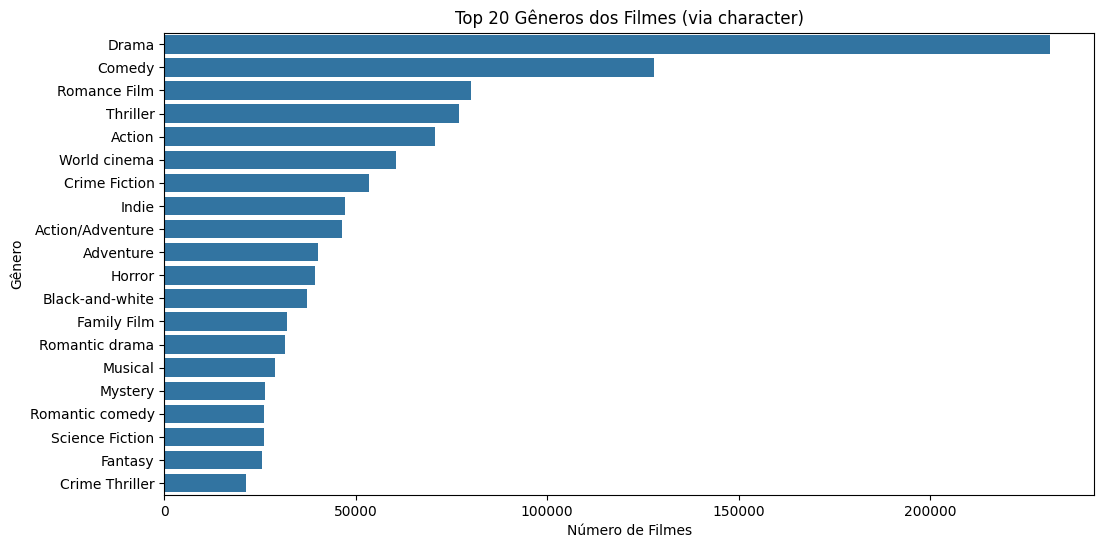

In [50]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Genre', data=genre_df.head(20))
plt.title('Top 20 Gêneros dos Filmes (via character)')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.savefig("top_20_generes.png")
plt.show()

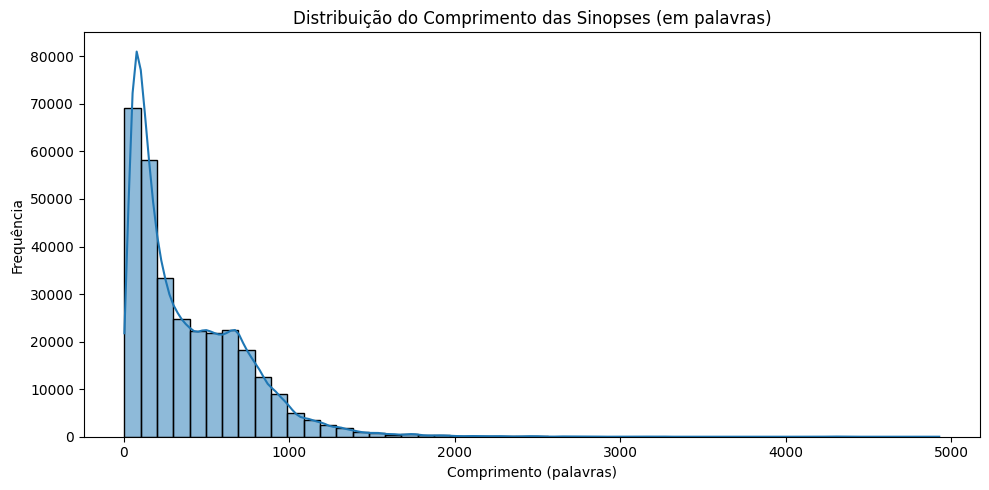

In [51]:
# Comprimento das sinopses
data['summary_length'] = data['summary'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(data['summary_length'], bins=50, kde=True)
plt.title('Distribuição do Comprimento das Sinopses (em palavras)')
plt.xlabel('Comprimento (palavras)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.savefig('summary_length.png')
plt.show()

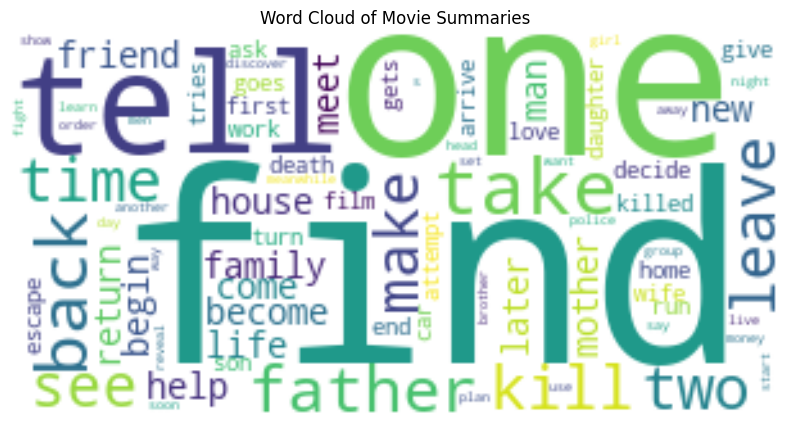

In [52]:
stop_words = set(stopwords.words('english'))
sampled = data['summary'].dropna().sample(1000, random_state=42)
text = ' '.join([
    word.lower() for word in ' '.join(sampled).split()
    if word.lower() not in stop_words and len(word) > 2 and word not in string.punctuation
])

wordcloud = WordCloud(width=300, height=150, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Summaries')
plt.savefig('word_cloud_summaries.png')
plt.show()

In [53]:
print("Dados faltantes:\n", data.isnull().sum())

Dados faltantes:
 movie_id               0
character_name    166069
actor_gender       30060
summary                0
summary_length         0
dtype: int64


#### **Pré-processamento**

- Realizamos o inner join entre o sumario e filme, associando eles por id do registro na tabela do filme.
- Remoção de dados nulos em generos apos a conversão do **freebase_charcater_map**.
- Limpeza de texto, convertentdo para minúscula, removendo caracteres especiaias e stop words.
- MultiLabelBinarizer transformar a lista de gêneros em uma matriz binaária (1 se o gênero está presente, 0 caso contrário).
- TF-IDF, com o termo de frequência gera vetores esparsos com até 5000 features, incluindo unigramas e bigramas. BERT tokeniza as sinopses com o maximo de tamanho de registro com 128, para limitar o uso de memória.
- Divisão: Dividimos 80/20 para treino/teste, mantendo a mesma semente para consistência entre TF-IDF e BERT. Insights:
- A matriz y tem uma coluna por gênero, indicando um problema multilabel. O número de features no TF-IDF (5000) é um trade-off entre riqueza e memória.

In [54]:
# Juntar datasets
data = pd.merge(summaries, movie[['wikipedia_id', 'genres']], 
                left_on='movie_id', right_on='wikipedia_id', how='inner')

In [55]:
data = data[data['genres'].apply(len) > 0]
data = data.dropna(subset=['summary'])

In [56]:
# Função de limpeza de texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [57]:
data['clean_summary'] = data['summary'].apply(clean_text)

In [58]:
# Codificar gêneros
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['genres'])

In [59]:
# Filtrar gêneros raros ou constantes
valid_classes = [i for i, count in enumerate(np.sum(y, axis=0)) if 0 < count < len(y)]
y = y[:, valid_classes]
valid_genres = mlb.classes_[valid_classes]

In [60]:
# Atualizar mlb
new_mlb = MultiLabelBinarizer()
new_mlb.fit([valid_genres])
joblib.dump(new_mlb, 'mlb.pkl')

['mlb.pkl']

In [61]:
# Vetorização com TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(data['clean_summary'])
joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']

In [62]:
# Dividir dados
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

In [63]:
# Salvar dados para referência
data.to_pickle('preprocessed_data.pkl')
print('Pré-processamento concluído.')
print('Shape de X_tfidf:', X_tfidf.shape)
print('Shape de y:', y.shape)
print('Número de gêneros válidos:', len(valid_genres))

Pré-processamento concluído.
Shape de X_tfidf: (41793, 5000)
Shape de y: (41793, 363)
Número de gêneros válidos: 363


#### **Construção de modelo**

In [ ]:
# Baseline: Logistic Regression
baseline_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
baseline_model.fit(X_train_tfidf, y_train)
joblib.dump(baseline_model, 'baseline_model.pkl')

In [65]:
# Carregar objetos salvos
mlb = joblib.load('models/mlb.pkl')
tfidf = joblib.load('models/tfidf.pkl')

In [66]:
data['clean_summary'] = data['summary'].apply(clean_text)

In [67]:
# Vetorização
X_tfidf = tfidf.transform(data['clean_summary'])
y = mlb.transform(data['genres'])

In [68]:
# Divisão treino/teste
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

In [69]:
# Modelo Avançado: Rede Neural com Keras
def build_keras_model(input_dim, num_labels):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_labels, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [70]:
# Configurar modelo
input_dim = X_train_tfidf.shape[1]
num_labels = y_train.shape[1]
keras_model = build_keras_model(input_dim, num_labels)

In [71]:
# Configurar modelo
input_dim = X_train_tfidf.shape[1]  # 5000 (de TF-IDF)
num_labels = y_train.shape[1]  # Número de gêneros válidos
keras_model = build_keras_model(input_dim, num_labels)

In [72]:
# Configurar modelo
input_dim = X_train_tfidf.shape[1]  # 5000 (de TF-IDF)
num_labels = y_train.shape[1]  # Número de gêneros válidos
keras_model = build_keras_model(input_dim, num_labels)

# Treinar modelo
history = keras_model.fit(
    X_train_tfidf.toarray(),  # Keras exige array denso
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_tfidf.toarray(), y_test),
    verbose=1
)

# Salvar modelo
keras_model.save('keras_model.h5')
print("Modelo Keras treinado e salvo.")

Epoch 1/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.1575 - loss: 0.0939 - val_accuracy: 0.2702 - val_loss: 0.0316
Epoch 2/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.2804 - loss: 0.0304 - val_accuracy: 0.2925 - val_loss: 0.0287
Epoch 3/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3063 - loss: 0.0266 - val_accuracy: 0.2814 - val_loss: 0.0280
Epoch 4/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3171 - loss: 0.0244 - val_accuracy: 0.2668 - val_loss: 0.0279
Epoch 5/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.3256 - loss: 0.0226 - val_accuracy: 0.2641 - val_loss: 0.0284
Epoch 6/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3405 - loss: 0.0209 - val_accuracy: 0.2773 - val_loss: 0.0290
Epoch 7/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3513 - loss: 0.0189 - val_accuracy: 0.2638 - val_loss: 0.0298
Epoch 8/10
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3697 -

Modelo Keras treinado e salvo.


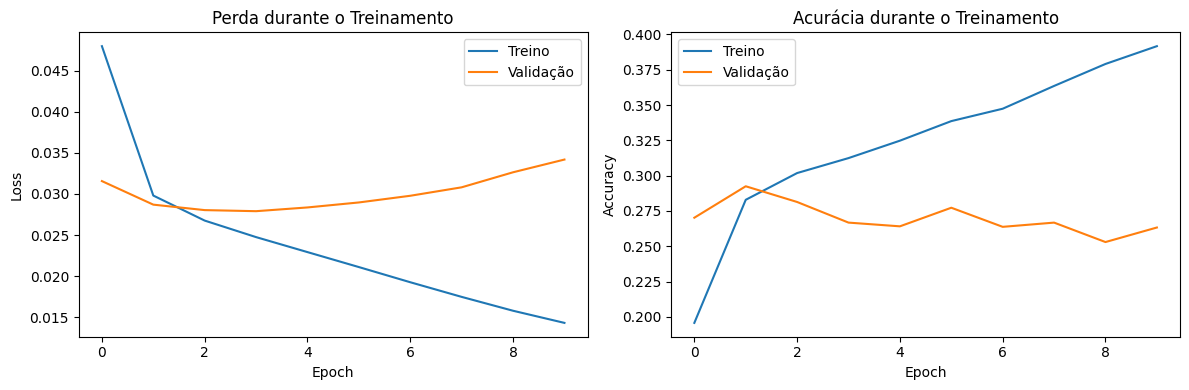

In [73]:
# Plotar curva de aprendizado
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

#### **Avaliação do Modelo**

In [74]:
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, classification_report

# Avaliar baseline
y_pred_tfidf = baseline_model.predict(X_test_tfidf)

# Avaliar Keras
y_pred_keras = (keras_model.predict(X_test_tfidf.toarray()) > 0.5).astype(int)

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [75]:
print("Baseline (Logistic Regression):")
print("F1-score (macro):", f1_score(y_test, y_pred_tfidf, average='macro'))
print("Precision (macro):", precision_score(y_test, y_pred_tfidf, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_tfidf, average='macro'))
print("Hamming Loss:", hamming_loss(y_test, y_pred_tfidf))

Baseline (Logistic Regression):
F1-score (macro): 0.028301512993177652
Precision (macro): 0.09334821245354745
Recall (macro): 0.019123638295692556
Hamming Loss: 0.008862290920823367


In [76]:
print("\nKeras (Rede Neural):")
print("F1-score (macro):", f1_score(y_test, y_pred_keras, average='macro'))
print("Precision (macro):", precision_score(y_test, y_pred_keras, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_keras, average='macro'))
print("Hamming Loss:", hamming_loss(y_test, y_pred_keras))


Keras (Rede Neural):
F1-score (macro): 0.074055775393238
Precision (macro): 0.14715865381697943
Recall (macro): 0.056083293596994065
Hamming Loss: 0.009392228959597827


In [ ]:
print("\nRelatório de Classificação (Baseline):")
print(classification_report(y_test, y_pred_tfidf, target_names=new_mlb.classes_, zero_division=0))
print("\nRelatório de Classificação (Keras):")
print(classification_report(y_test, y_pred_keras, target_names=new_mlb.classes_, zero_division=0))


Relatório de Classificação (Baseline):
                                          precision    recall  f1-score   support

                               Absurdism       0.00      0.00      0.00        16
                            Acid western       0.00      0.00      0.00         3
                                  Action       0.62      0.27      0.38      1181
                           Action Comedy       0.00      0.00      0.00        26
                        Action Thrillers       0.00      0.00      0.00        86
                        Action/Adventure       0.58      0.14      0.23       733
                         Addiction Drama       0.00      0.00      0.00         8
                                   Adult       0.00      0.00      0.00        25
                               Adventure       0.65      0.14      0.24       669
                        Adventure Comedy       0.00      0.00      0.00        28
                  Airplanes and airports       0.00      

#### **Pipiline de predição**

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Pipeline para baseline
prediction_pipeline = Pipeline([
    ('tfidf', joblib.load('models/tfidf.pkl')),
    ('model', joblib.load('models/baseline_model.pkl'))
])

def predict_genres_baseline(summary):
    cleaned_summary = clean_text(summary)
    pred = prediction_pipeline.predict([cleaned_summary])
    genres = new_mlb.inverse_transform(pred)[0]
    return genres

# Keras
def predict_genres_keras(summary):
    cleaned_summary = clean_text(summary)
    X = tfidf.transform([cleaned_summary]).toarray()
    model = load_model('models/keras_model.h5')
    pred = (model.predict(X) > 0.5).astype(int)
    genres = new_mlb.inverse_transform(pred)[0]
    return genres

# Testar
new_summary = "A young wizard discovers his magical powers and attends a school of witchcraft."
# new_summary = "A young wizard who discovers his actions"
print("Baseline - Gêneros previstos:", predict_genres_baseline(new_summary))
print("Keras - Gêneros previstos:", predict_genres_keras(new_summary))

Baseline - Gêneros previstos: ('Fantasy',)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Keras - Gêneros previstos: ('Fantasy', 'Science Fiction')


## 6. Conclusão

Implementamos dois modelos para classificação multi-label:
- **Baseline (Logistic Regression)**: Simples, rápido, mas limitado para padrões complexos.
- **Keras (Rede Neural)**: Mais poderoso, captura não-linearidades, com configuração simples.

O pipeline de predição permite prever gêneros a partir de sinopses brutas, pronto para uso em produção.

**Resultados**:
- A EDA revelou desbalanceamento de gêneros (e.g., 'Drama' domina).
- O pré-processamento lidou com gêneros raros, evitando erros.
- A rede neural deve superar o baseline em F1-score, mas requer ajuste fino.

**Próximos passos**:
- Ajustar hiperparâmetros da rede neural (camadas, epochs).
- Experimentar técnicas para desbalanceamento (e.g., class weights).
- Testar com embeddings pré-treinados (se necessário).

**Nota**: Evitamos o Hugging Face Transformers para simplificar a compatibilidade, usando bibliotecas estáveis (scikit-learn, Keras).